In [1]:
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt    
%matplotlib inline
import numpy as np
import os
import glob
import cv2

<h4> prepare training Data</h4>


In [22]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#unzipping and making directories---------------------------------
! mkdir train_dir
! unzip '/content/gdrive/MyDrive/Training_Smoking.zip' -d train_dir

Archive:  /content/gdrive/MyDrive/Training_Smoking.zip
   creating: train_dir/train_data/
  inflating: train_dir/train_data/other_0.avi  
  inflating: train_dir/train_data/other_1.avi  
  inflating: train_dir/train_data/other_10.avi  
  inflating: train_dir/train_data/other_11.avi  
  inflating: train_dir/train_data/other_12.avi  
  inflating: train_dir/train_data/other_13.avi  
  inflating: train_dir/train_data/other_14.avi  
  inflating: train_dir/train_data/other_15.avi  
  inflating: train_dir/train_data/other_16.avi  
  inflating: train_dir/train_data/other_17.avi  
  inflating: train_dir/train_data/other_18.avi  
  inflating: train_dir/train_data/other_19.avi  
  inflating: train_dir/train_data/other_2.avi  
  inflating: train_dir/train_data/other_20.avi  
  inflating: train_dir/train_data/other_21.avi  
  inflating: train_dir/train_data/other_22.avi  
  inflating: train_dir/train_data/other_23.avi  
  inflating: train_dir/train_data/other_24.avi  
  inflating: train_dir/train_da

In [ ]:
# !rm -rf /content/train_dir

In [2]:
! mkdir frame_dir

mkdir: cannot create directory ‘frame_dir’: File exists


In [3]:
#fuction gets the video and save the frames of videos to .jpg format
def get_frames(video_path, dest_path):
    file_name = video_path.split('.')[0].split('/')[-1]
    cap= cv2.VideoCapture(video_path)
    total_frames = int(cap.get(7))
    frame_rate = cap.get(5)
    # print(file_name,total_frames,frame_rate)
    frame_distance = total_frames//10
    
    count=0
    frame_count=0
    for i in range (total_frames): #iterating over all the frames of the video.
        ret, frame = cap.read()
        if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
            frame = f_prev
        elif ret==True:
            f_prev =frame
        frame_count +=1
        if ((frame_count ==(frame_distance)) and (count<10)):
            frame_count = 0
            cv2.imwrite(dest_path+'/'+file_name+'_'+ str(count)+".jpg",frame)
            count +=1
    cap.release()
    cv2.destroyAllWindows()

In [4]:
video_dir='/content/train_dir/train_data'
frame_dir='/content/frame_dir'

In [5]:
#save the frames of all videos
for i in range(len(os.listdir(video_dir))):
    video_path = video_dir + '/' + os.listdir(video_dir)[i]
    get_frames(video_path,frame_dir)
print("All frames written in the frame_dir Folder")

All frames written in the frame_dir Folder


In [6]:
img_high=220
img_width=220
frame_no_video=10

In [7]:
def get_train_data(file_name):
    training = []
    frames_to_select=[]
    for i , filename in enumerate(glob.glob(file_name)):

        image = cv2.imread(filename)
        img = cv2.resize(image, dsize=(img_high,img_width), interpolation=cv2.INTER_CUBIC)
        # normalizing the pixel value
        img = img/255
        training.append(img)
    return training


In [8]:
training = get_train_data(frame_dir + '/*.jpg')

In [9]:
# put label 1 for smoking and 0 for others
train_label =[]
for file in os.listdir(frame_dir):
    label = file.split('_')[0]
    if label == 'smoking':
        train_label.append(1)
    else:
        train_label.append(0)
print(len(train_label))


1760


In [10]:
vid_num=len(train_label)//frame_no_video
X = np.asarray(training)
y = np.asarray(train_label)
X=X.reshape(vid_num,frame_no_video, img_high, img_width, 3)
print(X.shape)
y=y.reshape(vid_num,frame_no_video,1)
print(y.shape)

(176, 10, 220, 220, 3)
(176, 10, 1)


In [11]:
# split data to train and validation
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)  

In [12]:
timestep=10
model = models.Sequential()
model.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(timestep,img_high,img_width,3)))
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, dropout=0.5))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 218, 218, 128) 3584      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 216, 216, 64)  73792     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 108, 108, 64)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 106, 106, 32)  18464     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 53, 53, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 89888)         0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 89888)         0

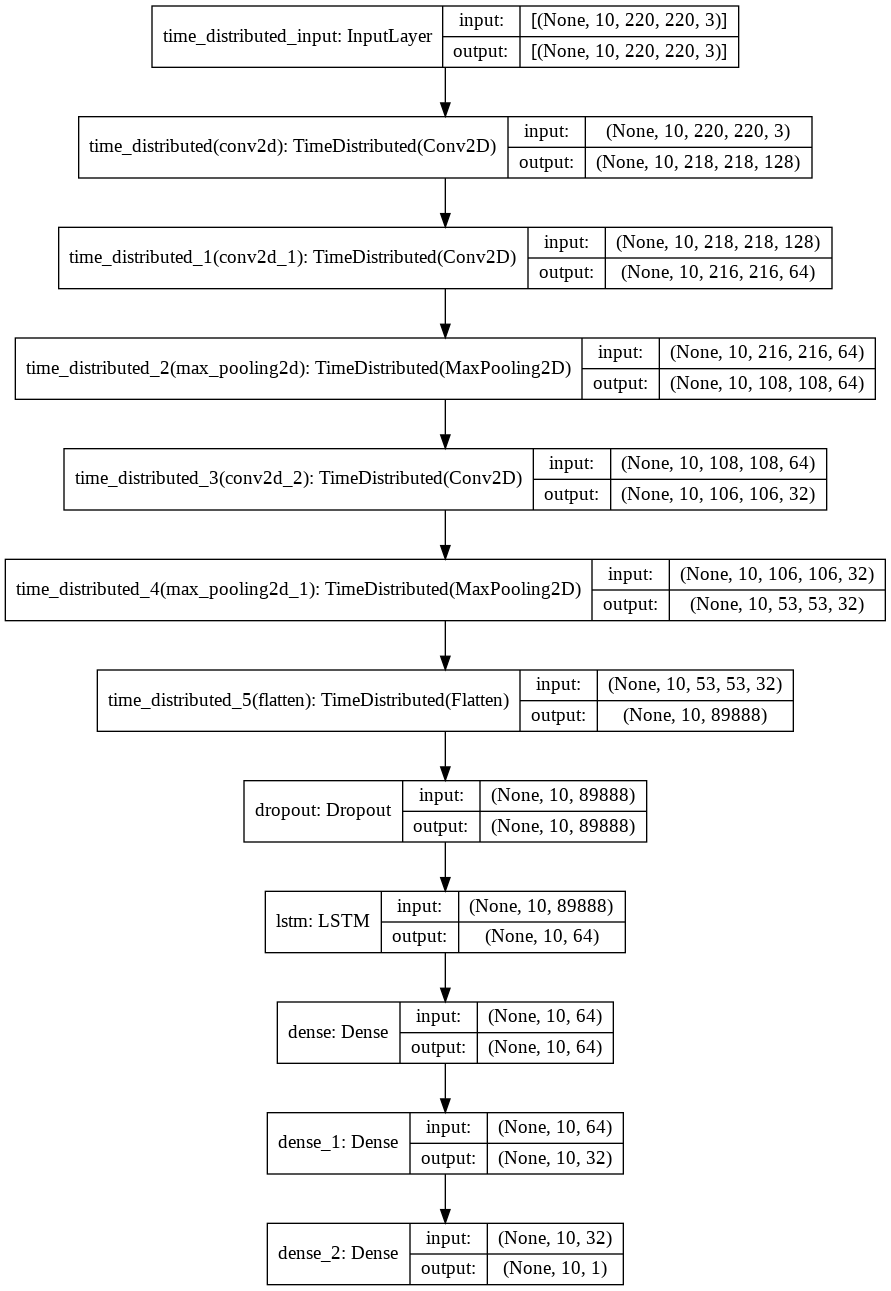

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=0.0001),metrics=['acc']) 

In [15]:
from keras.callbacks import ModelCheckpoint
path = F"/content/gdrive/MyDrive/model5.h5" 
checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [16]:
history = model.fit(x=x_train, y=y_train, validation_data = (x_valid,y_valid), batch_size=5, epochs=10,callbacks=[checkpoint])

Epoch 1/10
25/25 [==============================] - 44s 561ms/step - loss: 0.6948 - acc: 0.5098 - val_loss: 0.7037 - val_acc: 0.4887

Epoch 00001: val_loss improved from inf to 0.70368, saving model to /content/gdrive/MyDrive/model5.h5
Epoch 2/10
25/25 [==============================] - 10s 404ms/step - loss: 0.6830 - acc: 0.5758 - val_loss: 0.6269 - val_acc: 0.6604

Epoch 00002: val_loss improved from 0.70368 to 0.62688, saving model to /content/gdrive/MyDrive/model5.h5
Epoch 3/10
25/25 [==============================] - 10s 412ms/step - loss: 0.6055 - acc: 0.6778 - val_loss: 0.5505 - val_acc: 0.7264

Epoch 00003: val_loss improved from 0.62688 to 0.55049, saving model to /content/gdrive/MyDrive/model5.h5
Epoch 4/10
25/25 [==============================] - 11s 424ms/step - loss: 0.5231 - acc: 0.7648 - val_loss: 0.4918 - val_acc: 0.7943

Epoch 00004: val_loss improved from 0.55049 to 0.49177, saving model to /content/gdrive/MyDrive/model5.h5
Epoch 5/10
25/25 [==========================

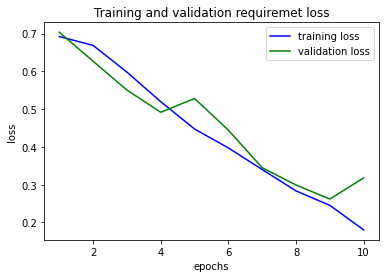

In [17]:
epochs = range(1,11)
plt.plot(epochs, history.history['loss'], 'b', label = 'training loss')
plt.plot(epochs, history.history['val_loss'], 'g', label = 'validation loss')
plt.title('Training and validation requiremet loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [18]:
! mkdir test_dir
! unzip '/content/gdrive/MyDrive/Test_Smoking.zip' -d test_dir
! mkdir frames_test

Archive:  /content/gdrive/MyDrive/Test_Smoking.zip
   creating: test_dir/Test_Smoking/
  inflating: test_dir/Test_Smoking/other_0.avi  
  inflating: test_dir/Test_Smoking/other_1.avi  
  inflating: test_dir/Test_Smoking/other_2.avi  
  inflating: test_dir/Test_Smoking/other_3.avi  
  inflating: test_dir/Test_Smoking/other_4.avi  
  inflating: test_dir/Test_Smoking/other_5.avi  
  inflating: test_dir/Test_Smoking/other_6.avi  
  inflating: test_dir/Test_Smoking/other_7.avi  
  inflating: test_dir/Test_Smoking/other_8.avi  
  inflating: test_dir/Test_Smoking/other_9.avi  
  inflating: test_dir/Test_Smoking/smoking_0.avi  
  inflating: test_dir/Test_Smoking/smoking_1.avi  
  inflating: test_dir/Test_Smoking/smoking_2.avi  
  inflating: test_dir/Test_Smoking/smoking_3.avi  
  inflating: test_dir/Test_Smoking/smoking_4.avi  
  inflating: test_dir/Test_Smoking/smoking_5.avi  
  inflating: test_dir/Test_Smoking/smoking_6.avi  
  inflating: test_dir/Test_Smoking/smoking_7.avi  
  inflating: te

In [19]:
test_dir='/content/test_dir/Test_Smoking'
frames_test='/content/frames_test'

In [ ]:
#!rm -rf /content/frames_test

In [20]:
#save the frames of all videos
for i in range(len(os.listdir(test_dir))):
    video_path = test_dir + '/' + os.listdir(test_dir)[i]
    get_frames(video_path,frames_test)
print("All frames written in the frame_dir Folder")

All frames written in the frame_dir Folder


In [21]:
testing = get_train_data(frames_test + '/*.jpg')

In [22]:
test_label =[]
for file in os.listdir(frames_test):
    label = file.split('_')[0]
    if label == 'smoking':
        test_label.append(1)
    else:
        test_label.append(0)
print(len(test_label))

200


In [23]:
vid_num=len(test_label)//frame_no_video
X_test = np.asarray(testing)
y_test = np.asarray(test_label)
X_test=X_test.reshape(vid_num,frame_no_video, img_high, img_width, 3)
print(X_test.shape)
y_test=y_test.reshape(vid_num,frame_no_video,1)
print(y_test.shape)

(20, 10, 220, 220, 3)
(20, 10, 1)


In [24]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1/1 [==============================] - 5s 5s/step - loss: 0.7155 - acc: 0.6550
acc: 65.50%
